In [1]:
import pandas as pd
import numpy as np
import torch

from transformers import BertForSequenceClassification, BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

In [2]:
t = tokenizer.encode("don't be so judgmental", return_tensors='pt')  # tokenizer will return pytorch tensors

print(t)
print(tokenizer.decode(t[0]))  # print decoded string with special tokens included
print(tokenizer.decode(t[0], skip_special_tokens=True))

tensor([[ 101, 1274,  112,  189, 1129, 1177, 9228, 1348,  102]])
[CLS] don't be so judgmental [SEP]
don't be so judgmental


In [3]:
df = pd.read_csv('../data/svicar iz milana.csv')
print(len(df))
print(df['Discussion Type'].unique())
print(df[df['Discussion Type'].isnull()])
print(df[df['Discussion Type'] == 'Others'])

df = df.dropna(subset=['Discussion Type'])
df = df[df['Discussion Type'] != 'Others']
print("\n\nFIXED")
print(len(df))
print(df['Discussion Type'].unique())
print(df[df['Discussion Type'].isnull()])
print(df[df['Discussion Type'] == 'Others'])


712
['Social' 'Seminar' 'Procedure' nan 'Deliberation' 'UX'
 'Imaginative Entry' 'Others']
    Message Discussion Type
13      mor             NaN
59        s             NaN
72   uwgyeu             NaN
77      ha"             NaN
85        w             NaN
175   darla             NaN
                                               Message Discussion Type
201  So, where have we landed: Lady or tiger? Trial...          Others
225  I agree that the princess could just banish th...          Others
236                                    Yay you got it!          Others
244  Oh I see, there are two questions here.  I fee...          Others
310  Looks good! I guess we can complete the post s...          Others


FIXED
701
['Social' 'Seminar' 'Procedure' 'Deliberation' 'UX' 'Imaginative Entry']
Empty DataFrame
Columns: [Message, Discussion Type]
Index: []
Empty DataFrame
Columns: [Message, Discussion Type]
Index: []


In [4]:
print(df["Discussion Type"])
df = df.rename(columns={'Discussion Type': 'label'})
print(df["label"])

0            Social
1           Seminar
2           Seminar
3           Seminar
4           Seminar
           ...     
707       Procedure
708       Procedure
709       Procedure
710       Procedure
711    Deliberation
Name: Discussion Type, Length: 701, dtype: object
0            Social
1           Seminar
2           Seminar
3           Seminar
4           Seminar
           ...     
707       Procedure
708       Procedure
709       Procedure
710       Procedure
711    Deliberation
Name: label, Length: 701, dtype: object


In [5]:
from datasets import DatasetDict, Dataset

In [6]:
dataset = Dataset.from_pandas(df)
print(dataset)

Dataset({
    features: ['Message', 'label', '__index_level_0__'],
    num_rows: 701
})


In [7]:
train_dataset = dataset.shuffle(seed=1).select(range(int(len(dataset) * 0.65)))
valid_dataset = dataset.shuffle(seed=1).select(range(int(len(dataset) * 0.65), int(len(dataset) * 0.85)))
test_dataset = dataset.shuffle(seed=1).select(range(int(len(dataset) * 0.85), len(dataset)))

In [8]:
dataset_dict = DatasetDict({
    'train': train_dataset,
    'validate': valid_dataset,
    'test': test_dataset
})

In [9]:
train_dataset = dataset_dict['train']
valid_dataset = dataset_dict['validate']
test_dataset = dataset_dict['test']

In [10]:
print(dataset_dict['train'][0])

{'Message': 'Each time you submit, the lady talks back to you and her icon changes.', 'label': 'UX', '__index_level_0__': 536}


In [11]:
target_param = "orig"
def preprocess_function(examples):
    model_inputs = tokenizer(examples["Message"], max_length=tokenizer.model_max_length, truncation=True)
    print(model_inputs)

    #model_inputs["labels"] =
    return model_inputs

In [12]:
tokenized_datasets = dataset_dict.map(preprocess_function, batched=True, batch_size=16)

Map:   0%|          | 0/455 [00:00<?, ? examples/s]

{'input_ids': [[101, 2994, 1159, 1128, 12295, 117, 1103, 5141, 7430, 1171, 1106, 1128, 1105, 1123, 15802, 2607, 119, 102], [101, 1337, 112, 188, 170, 1541, 14222, 2365, 1553, 117, 18943, 106, 102], [101, 2389, 9961, 1397, 1989, 1175, 1209, 1129, 170, 6324, 1106, 4684, 119, 102], [101, 146, 787, 1325, 4031, 1107, 1770, 1105, 5194, 1106, 1122, 102], [101, 17035, 117, 1177, 1184, 1128, 1341, 1103, 3243, 1132, 136, 102], [101, 2160, 117, 6243, 1128, 1315, 119, 2750, 2261, 2490, 119, 131, 114, 102], [101, 11901, 102], [101, 146, 1176, 1122, 102], [101, 8790, 8138, 3261, 1105, 9075, 14556, 117, 146, 1821, 1303, 1105, 2407, 7747, 1128, 1241, 1132, 119, 102], [101, 146, 1400, 2446, 1283, 2959, 106, 102], [101, 5979, 3243, 136, 1176, 1103, 5250, 18378, 136, 102], [101, 1753, 1541, 117, 1185, 119, 23243, 1152, 4734, 1293, 2927, 25964, 1665, 1119, 1110, 119, 146, 1631, 1176, 1119, 112, 188, 170, 1118, 118, 1103, 118, 1520, 3271, 1104, 2564, 102], [101, 146, 1138, 1185, 3319, 1112, 1106, 1134, 111

Map:   0%|          | 0/140 [00:00<?, ? examples/s]

{'input_ids': [[101, 8790, 1287, 117, 102], [101, 7677, 9186, 117, 102], [101, 23330, 117, 1208, 146, 1267, 1184, 1195, 1132, 2033, 1120, 119, 119, 146, 1354, 1195, 1125, 1106, 3277, 1122, 1113, 1103, 1286, 119, 146, 1267, 1208, 1115, 1122, 12543, 1175, 1111, 1234, 1106, 5194, 1105, 14609, 102], [101, 146, 1145, 1341, 1115, 1256, 1191, 1103, 2226, 4090, 1149, 1115, 1131, 1450, 1103, 3581, 1119, 1209, 1221, 1115, 1719, 3026, 1115, 1131, 2228, 1110, 170, 7703, 1107, 1157, 1319, 1268, 119, 1153, 18907, 1719, 1236, 102], [101, 3956, 106, 102], [101, 1573, 146, 112, 182, 1136, 1612, 1191, 1103, 2226, 1156, 112, 1396, 1125, 170, 1289, 1107, 4518, 1123, 7559, 1481, 1103, 1442, 119, 102], [101, 1192, 112, 1231, 1303, 1111, 149, 6258, 1545, 13144, 1495, 1137, 1111, 1330, 1705, 136, 102], [101, 1105, 13322, 1814, 1105, 5426, 8366, 1104, 1103, 3719, 1206, 1293, 1103, 9309, 26084, 8350, 1113, 1164, 1140, 2280, 1103, 1442, 1114, 1103, 5141, 1133, 3742, 9541, 1140, 2280, 1103, 1442, 1114, 1103, 1377

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

{'input_ids': [[101, 9954, 117, 146, 5340, 1114, 1128, 1115, 1103, 2226, 1110, 1177, 8050, 19853, 1204, 1115, 1117, 1449, 1110, 3264, 1115, 1119, 1156, 2548, 1117, 1797, 1106, 1122, 119, 146, 1341, 1119, 1110, 4742, 24255, 1118, 1117, 1319, 4495, 117, 1105, 5115, 1115, 1112, 2226, 1119, 1431, 1145, 1129, 1107, 2965, 1104, 2490, 112, 188, 7012, 119, 1272, 1191, 1119, 5098, 3097, 1123, 1119, 1156, 1136, 1138, 1850, 1103, 1141, 1299, 1115, 1131, 3097, 1154, 1103, 8176, 119, 1124, 1156, 1138, 1427, 5000, 1106, 1294, 1123, 2816, 102], [101, 1135, 1541, 1180, 1129, 9829, 1719, 1236, 119, 2066, 2590, 3243, 1137, 3593, 1126, 3830, 119, 119, 119, 119, 102], [101, 146, 2059, 1131, 1850, 1140, 1106, 1103, 13778, 119, 138, 2226, 112, 188, 1797, 1156, 1136, 1328, 1106, 2934, 170, 7559, 1137, 1267, 1140, 1114, 1330, 1590, 119, 102], [101, 119, 119, 119, 1173, 1103, 1269, 1111, 1103, 1248, 1226, 136, 102], [101, 146, 1577, 112, 189, 1719, 119, 102], [101, 1135, 1156, 1129, 1198, 170, 1645, 1115, 1142

In [13]:
label2id = {'Social': 0, 'Seminar': 1,'Procedure': 2,'Deliberation': 3, 'UX': 4, 'Imaginative Entry': 5}
def map_labels_to_ids(example):
    example['label'] = label2id[example['label']]
    return example

tokenized_datasets['train'] = tokenized_datasets['train'].map(map_labels_to_ids)
tokenized_datasets['validate'] = tokenized_datasets['validate'].map(map_labels_to_ids)
tokenized_datasets['test'] = tokenized_datasets['test'].map(map_labels_to_ids)

Map:   0%|          | 0/455 [00:00<?, ? examples/s]

Map:   0%|          | 0/140 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

In [14]:
print(tokenized_datasets['train'][2])

{'Message': 'Maybe sometime next week there will be a button to push.', 'label': 4, '__index_level_0__': 171, 'input_ids': [101, 2389, 9961, 1397, 1989, 1175, 1209, 1129, 170, 6324, 1106, 4684, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [15]:
print(tokenized_datasets['train'][0].keys())

dict_keys(['Message', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'])


In [23]:
id2label = {0: 'Social', 1: 'Seminar', 2: 'Procedure', 3: 'Deliberation', 4: 'UX', 5: 'Imaginative Entry'}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=6, id2label=id2label, label2id=label2id).to(device)

cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [25]:
import evaluate
from sklearn.metrics import confusion_matrix, f1_score

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    print(eval_pred)
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    cm = confusion_matrix(labels, predictions)
    f1_micro = f1_score(labels, predictions, average='micro')
    return {
        "accuracy": accuracy.compute(predictions=predictions, references=labels),
        "confusion_matrix": cm.tolist(),
        "f1_micro": f1_micro
    }

In [26]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./runs",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validate"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [27]:
trainer.train()

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.2891675233840942, 'eval_accuracy': {'accuracy': 0.5571428571428572}, 'eval_confusion_matrix': [[4, 19, 0, 0, 0, 0], [0, 74, 0, 0, 0, 0], [0, 11, 0, 0, 0, 0], [0, 18, 0, 0, 0, 0], [1, 10, 0, 0, 0, 0], [0, 3, 0, 0, 0, 0]], 'eval_f1_micro': 0.5571428571428572, 'eval_runtime': 2.0046, 'eval_samples_per_second': 69.84, 'eval_steps_per_second': 8.979, 'epoch': 1.0}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 0.9668591022491455, 'eval_accuracy': {'accuracy': 0.65}, 'eval_confusion_matrix': [[12, 9, 0, 2, 0, 0], [0, 71, 0, 3, 0, 0], [3, 1, 0, 7, 0, 0], [2, 8, 0, 8, 0, 0], [2, 1, 0, 8, 0, 0], [0, 2, 0, 1, 0, 0]], 'eval_f1_micro': 0.65, 'eval_runtime': 2.036, 'eval_samples_per_second': 68.762, 'eval_steps_per_second': 8.841, 'epoch': 2.0}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 0.958507239818573, 'eval_accuracy': {'accuracy': 0.6928571428571428}, 'eval_confusion_matrix': [[13, 8, 1, 1, 0, 0], [0, 70, 0, 4, 0, 0], [2, 0, 4, 5, 0, 0], [1, 5, 1, 10, 1, 0], [2, 1, 0, 8, 0, 0], [0, 1, 0, 2, 0, 0]], 'eval_f1_micro': 0.6928571428571428, 'eval_runtime': 2.028, 'eval_samples_per_second': 69.034, 'eval_steps_per_second': 8.876, 'epoch': 3.0}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 0.9685865044593811, 'eval_accuracy': {'accuracy': 0.7142857142857143}, 'eval_confusion_matrix': [[12, 7, 2, 1, 1, 0], [0, 70, 1, 2, 1, 0], [2, 1, 5, 2, 1, 0], [2, 7, 1, 7, 1, 0], [2, 1, 0, 2, 6, 0], [0, 2, 0, 0, 1, 0]], 'eval_f1_micro': 0.7142857142857143, 'eval_runtime': 2.008, 'eval_samples_per_second': 69.722, 'eval_steps_per_second': 8.964, 'epoch': 4.0}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.0088608264923096, 'eval_accuracy': {'accuracy': 0.7142857142857143}, 'eval_confusion_matrix': [[13, 8, 1, 0, 1, 0], [0, 70, 1, 3, 0, 0], [2, 1, 4, 2, 2, 0], [1, 6, 1, 9, 1, 0], [2, 1, 0, 4, 4, 0], [0, 2, 0, 0, 1, 0]], 'eval_f1_micro': 0.7142857142857143, 'eval_runtime': 2.048, 'eval_samples_per_second': 68.359, 'eval_steps_per_second': 8.789, 'epoch': 5.0}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.0104025602340698, 'eval_accuracy': {'accuracy': 0.7142857142857143}, 'eval_confusion_matrix': [[12, 6, 2, 1, 2, 0], [0, 68, 1, 4, 1, 0], [1, 1, 5, 2, 2, 0], [1, 6, 1, 9, 1, 0], [2, 1, 0, 2, 6, 0], [0, 2, 0, 0, 1, 0]], 'eval_f1_micro': 0.7142857142857143, 'eval_runtime': 2.149, 'eval_samples_per_second': 65.148, 'eval_steps_per_second': 8.376, 'epoch': 6.0}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.0496615171432495, 'eval_accuracy': {'accuracy': 0.7214285714285714}, 'eval_confusion_matrix': [[12, 7, 2, 1, 1, 0], [0, 69, 1, 4, 0, 0], [1, 1, 5, 2, 2, 0], [1, 7, 1, 8, 1, 0], [2, 1, 0, 1, 7, 0], [0, 2, 0, 0, 1, 0]], 'eval_f1_micro': 0.7214285714285713, 'eval_runtime': 2.279, 'eval_samples_per_second': 61.431, 'eval_steps_per_second': 7.898, 'epoch': 7.0}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.0814805030822754, 'eval_accuracy': {'accuracy': 0.7214285714285714}, 'eval_confusion_matrix': [[12, 7, 2, 1, 1, 0], [0, 68, 1, 4, 1, 0], [0, 0, 7, 3, 1, 0], [1, 7, 0, 9, 1, 0], [2, 1, 0, 3, 5, 0], [0, 2, 0, 0, 1, 0]], 'eval_f1_micro': 0.7214285714285713, 'eval_runtime': 2.091, 'eval_samples_per_second': 66.954, 'eval_steps_per_second': 8.608, 'epoch': 8.0}
{'loss': 0.5774, 'grad_norm': 1.8245394229888916, 'learning_rate': 2.456140350877193e-06, 'epoch': 8.77}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.1113771200180054, 'eval_accuracy': {'accuracy': 0.7285714285714285}, 'eval_confusion_matrix': [[12, 7, 2, 1, 1, 0], [0, 68, 1, 4, 1, 0], [0, 0, 7, 3, 1, 0], [1, 6, 0, 10, 1, 0], [2, 1, 0, 3, 5, 0], [0, 2, 0, 0, 1, 0]], 'eval_f1_micro': 0.7285714285714285, 'eval_runtime': 2.105, 'eval_samples_per_second': 66.509, 'eval_steps_per_second': 8.551, 'epoch': 9.0}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.1094872951507568, 'eval_accuracy': {'accuracy': 0.7357142857142858}, 'eval_confusion_matrix': [[12, 6, 2, 1, 2, 0], [0, 68, 1, 4, 1, 0], [0, 0, 7, 3, 1, 0], [1, 6, 0, 10, 1, 0], [2, 1, 0, 2, 6, 0], [0, 2, 0, 0, 1, 0]], 'eval_f1_micro': 0.7357142857142858, 'eval_runtime': 2.189, 'eval_samples_per_second': 63.957, 'eval_steps_per_second': 8.223, 'epoch': 10.0}


RuntimeError: [enforce fail at ..\caffe2\serialize\inline_container.cc:337] . unexpected pos 666348352 vs 666348240

In [28]:
results = trainer.predict(tokenized_datasets["test"])
print(results.metrics)

  0%|          | 0/14 [00:00<?, ?it/s]

{'test_loss': 0.9757512211799622, 'test_accuracy': {'accuracy': 0.7169811320754716}, 'test_confusion_matrix': [[8, 2, 2, 0, 0, 0], [1, 50, 0, 1, 1, 0], [0, 1, 2, 3, 2, 0], [0, 4, 2, 10, 3, 0], [1, 0, 0, 2, 6, 0], [0, 4, 0, 0, 1, 0]], 'test_f1_micro': 0.7169811320754716, 'test_runtime': 1.3821, 'test_samples_per_second': 76.692, 'test_steps_per_second': 10.129}


<Axes: >

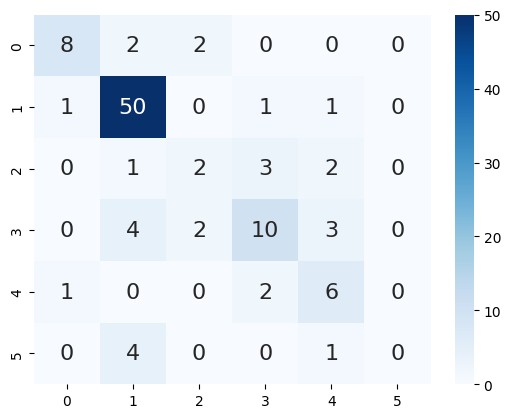

In [29]:
import matplotlib.pyplot as plt
import seaborn as sn
array = results.metrics['test_confusion_matrix']

df_cm = pd.DataFrame(array, range(6), range(6))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap='Blues')

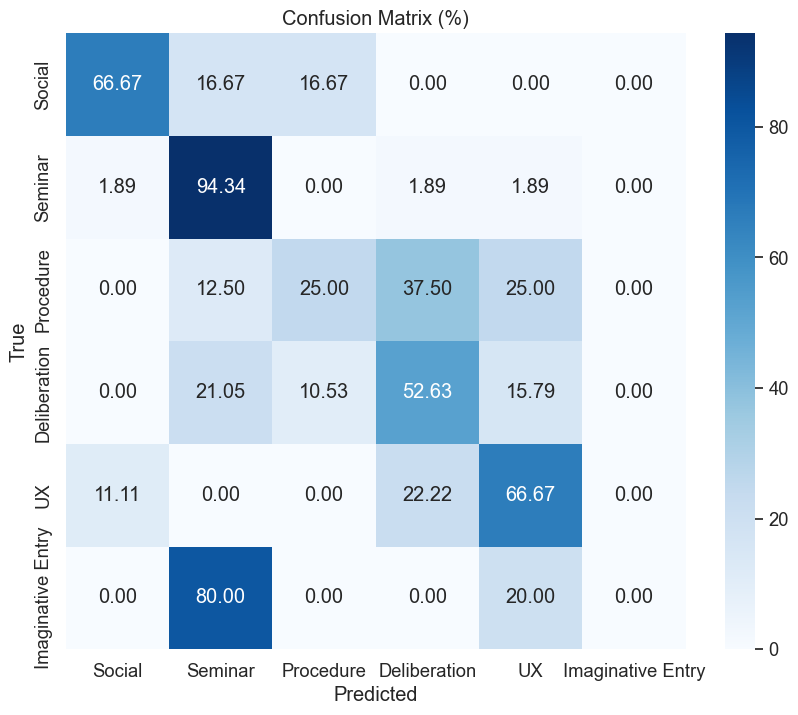

In [30]:
confusion_matrix_data = np.array(array)     

total_per_row = np.sum(confusion_matrix_data, axis=1)
confusion_matrix_data_percentages = (confusion_matrix_data.T / total_per_row).T * 100

# Plot confusion matrix with percentages
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(10, 8))
    sn.set(font_scale=1.2)  # Adjust to fit your needs
    sn.heatmap(cm, annot=True, cmap='Blues', fmt='.2f', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (%)')
    plt.show()

# Labels for confusion matrix
labels = ['Social', 'Seminar', 'Procedure', 'Deliberation', 'UX', 'Imaginative Entry']

# Plotting confusion matrix
plot_confusion_matrix(np.array(confusion_matrix_data_percentages), labels)